In [1]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
  !pip install gdown
  !pip3 install pillow==8.2.0
  !pip install neptune-client
  !pip install neptune-client neptune-tensorboard
  !pip install neptune-contrib

In [2]:
import neptune
NEPTUNE_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMGUxMmQ1NC00ZDU4LTQ4ZGYtOWJjOC0xYTJkYjJmYmJiZDMifQ=='
run = neptune.init(project_qualified_name='ch.kalavritinos/kvasir-cls', api_token=NEPTUNE_TOKEN)

In [3]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MAI/thesis/source


In [1]:
# %cd /content/

In [2]:
# !git clone https://github.com/simula/hyper-kvasir.git

In [6]:
print(images.shape, labels.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4])


In [2]:
import torch
import numpy as np
npy_file = np.load('/home/charis/kul-thesis/OAA/results_voc/exp2/results_cam/2007_000032.npy', allow_pickle=True)

In [3]:
import torch
import numpy as np
npy_file = np.load('/home/charis/kul-thesis/OAA/results_kvasir/exp8_new/results_cam/0a0b455d-d3dd-4be4-a6a3-90f81d8c8f36.npy', allow_pickle=True)


In [4]:
cam_file = npy_file[()]

In [5]:
cam_file

{tensor(0): array([[-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
         -9.9999006e-06, -9.9999006e-06, -9.9999006e-06],
        [-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
         -9.9999006e-06, -9.9999006e-06, -9.9999006e-06],
        [-9.9999006e-06, -9.9999006e-06, -9.9999006e-06, ...,
         -9.9999006e-06, -9.9999006e-06, -9.9999006e-06],
        ...,
        [-5.2964845e-04, -5.5503828e-04, -4.8955937e-04, ...,
          2.8331091e-03,  2.8797928e-03,  2.8616907e-03],
        [-5.6949450e-04, -5.9343327e-04, -5.3169648e-04, ...,
          2.8797928e-03,  2.9272430e-03,  2.9088438e-03],
        [-5.5404403e-04, -5.7854544e-04, -5.1535753e-04, ...,
          2.8616907e-03,  2.9088436e-03,  2.8905601e-03]], dtype=float32)}

In [1]:
import cv2
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

In [6]:
import torch.nn.functional as F
def get_strided_size(orig_size, stride):
    return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)

def resize_for_tensors(tensors, size, mode='bilinear', align_corners=False):
    return F.interpolate(tensors, size, mode=mode, align_corners=align_corners)


In [7]:
t = []
for i, key in enumerate(cam_file.keys()):
        ori_w, ori_h = cam_file[key].shape
        strided_size = get_strided_size((ori_h, ori_w), 4)
        # temp = resize_for_tensors(cam_file[key], strided_size)[0]
        # temp = image_resize(cam_file[key], width=125)
        # t.append(temp)
# new_cam = np.stack(t, axis=0)


In [8]:
list(cam_file.keys())[0]

tensor(0)

In [9]:
cam_file[list(cam_file.keys())[0]].shape

(224, 224)

In [10]:
strided_size

(56, 56)

In [11]:
t2 = cv2.resize(cam_file[list(cam_file.keys())[0]], strided_size, interpolation = cv2.INTER_CUBIC)

In [12]:
t2.shape

(56, 56)

In [13]:
npy_file2 = np.load('/home/charis/kul-thesis/OAA/2007_000032.npy', allow_pickle=True)
cam = npy_file2[()]['cam']

FileNotFoundError: [Errno 2] No such file or directory: '/home/charis/kul-thesis/OAA/2007_000032.npy'

In [29]:
type(cam), cam.shape

(torch.Tensor, torch.Size([2, 71, 125]))

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

In [9]:
dir2 = '/home/charis/kul-thesis/VOCdevkit/VOC2012/'
dir3 = '/home/charis/kul-thesis/OAA/scripts/experiments/predictions/DeepLabv3+@ResNet-101@Fix@GN@val@scale=0.5,1.0,1.5,2.0@iteration=10/'
alpha = 0.20
beta = 1 - alpha

In [39]:
import numpy as np
import time
import os
from PIL import Image
import cv2
import logging
from os.path import exists 
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
from skimage import color

colormaps = ['#7F0000', '#007F00', '#7F7F00', '#00007F', '#7F007F', '#007F7F', '#7F7F7F', '#3F0000', '#BF0000', '#3F7F00',
                        '#BF7F00', '#3F007F', '#BF007F', '#3F7F7F', '#BF7F7F', '#003F00', '#7F3F00', '#00BF00', '#7FBF00', '#003F7F']

colormaps = ['#7F0000', '#007F00', '#7F7F00', '#00007F', '#7F007F', '#007F7F', '#7F7F7F', '#3F0000', '#BF0000', '#3F7F00',
                        '#BF7F00', '#3F007F', '#BF007F', '#3F7F7F', '#BF7F7F', '#003F00', '#7F3F00', '#00BF00', '#7FBF00', '#003F7F']
                        
categories = ['background', 'aeroplane','bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
              'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

def colormap(index):
    # Return custom colormap
    return mpl.colors.LinearSegmentedColormap.from_list('cmap', [colormaps[0], colormaps[index+1], '#FFFFFF'], 256)


In [46]:
colormaps_rgb = [list(int(el.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for el in colormaps]

In [38]:
h = '#7F0000'.lstrip('#')
print('RGB =', tuple(int(h[i:i+2], 16) for i in (0, 2, 4)))

RGB = (127, 0, 0)


In [50]:
# mapp = [[127,0,0], [0,127,0], [127,127,0], [0,0,127], [127,0,127], [127,127,127], [63,0,0], [191,0,0], [63,127,0],[191,127,0], [63,0,127], [191,0,127], [63,127,127], [191,127,127], [0,63,0], [127,63,0], [0,191,0], [127,191,0], [0,63,127]]
seg_dir = '/home/charis/kul-thesis/OAA/scripts/experiments/predictions/DeepLabv3+@ResNet-101@Fix@GN@val@scale=0.5,1.0,1.5,2.0@iteration=10/seg'
for filename in os.listdir(dir3):
        if filename.endswith(".png"):
            size = np.size(filename)
            filename2 = filename[:size - 5]
            name = '{}JPEGImages/{}.jpg'.format(dir2, filename2)
            img = cv2.imread(name)
            seg = cv2.imread(dir3+filename, cv2.IMREAD_GRAYSCALE)
            print(np.unique(seg))
            height, width = seg.shape[0],seg.shape[1]
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
            a = color.label2rgb(seg, img, alpha=0.3, bg_label=0, kind='avg')
            # print(len(np.unique(a)))
            save_name = '{}/{}.png'.format(seg_dir, filename2)
            # print(save_name)
            min_value = np.min(a)
            max_value = np.max(a)
            a = (a - min_value) / (max_value - min_value + 1e-8)
            a = np.array(a*255, dtype = np.uint8)
        # break

[ 0 13]
[0 7]
[ 0 15]
[ 0 12]
[ 0  9 11]
[ 0  2  7 15]
[0 9]
[0 1]
[ 0 10]
[ 0 12]
[0 8]
[ 0 14]
[0 7]
[0 8]
[ 0 15]
[0 1]
[0 3]
[0 6]
[ 0 15]
[ 0 12]
[ 0 12]
[ 0 13 15]
[0 8]
[ 0 12 15]
[0 6]
[ 0 10]
[ 0 12 14]
[0 7]
[0 2]
[ 0 10 15]
[0 9]
[ 0 15]
[ 0 13 15]
[ 0 17]
[ 0 12 15]
[0 1]
[0]
[0 6]
[0]
[0 5]
[0]
[0 2]
[ 0  2 15]
[0 3]
[0 2]
[0 1]
[ 0 15 20]
[ 0 12]
[0 4]
[ 0 15]
[0 7]
[0 6]
[0 3]
[ 0 15]
[0 4]
[ 0 12]
[ 0 20]
[0 6 7]
[0 6]
[ 0 11 15]
[ 0 17]
[ 0 12]
[0 6]
[ 0 19]
[ 0 10]
[0 4]
[ 0 12 13 15]
[ 0 12]
[ 0 13]
[ 0 15]
[0 6 7]
[ 0  9 18]
[0 1]
[ 0 12]
[ 0 13 15]
[ 0 20]
[ 0  5 15]
[ 0 20]


KeyboardInterrupt: 

# Kvasir dataloaders


In [8]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [43]:
train_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train'
test_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/test'
# train_dir = os.path.join(os.getcwd(),'kvasir-dataset-v2-folds/1/train')

In [44]:
def get_data_loader(data_dir, batch_size=32, train=True):
    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    # ImageFolder with root directory and defined transformation methods for batch as well as data augmentation
    if train:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['train'])
    else:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['test'])
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

    return data.class_to_idx, data_loader 

In [45]:
torch.multiprocessing.freeze_support()
mapping, train_data_loader = get_data_loader(data_dir=train_dir, batch_size=8, train=True)
mapping, test_data_loader = get_data_loader(data_dir=test_dir, batch_size=8, train=False)

In [46]:
for bat in train_data_loader:
    print(bat[2])
    break

('/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/esophagitis/kvasir_v2__fold_1_train_class_esophagitis_frame_579.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/normal-pylorus/kvasir_v2__fold_1_train_class_normal-pylorus_frame_875.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/normal-cecum/kvasir_v2__fold_1_train_class_normal-cecum_frame_686.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/polyps/kvasir_v2__fold_1_train_class_polyps_frame_265.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/normal-pylorus/kvasir_v2__fold_1_train_class_normal-pylorus_frame_608.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/dyed-lifted-polyps/kvasir_v2__fold_1_train_class_dyed-lifted-polyps_frame_107.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/esophagitis/kvasir_v2__fold_1_train_class_esophagitis_frame_447.jpg', '/home/charis/kul-thesis/kvasir-dataset-v2-folds/1/train/dyed-resection-margins/kvasir_v2__f

In [47]:
import pathlib
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

In [48]:
total_train = len(list(train_data_dir.glob('*/*.jpg')))
total_val = len(list(test_data_dir.glob('*/*.jpg')))
total_train

7200

In [49]:
#get the class names
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['normal-cecum', 'dyed-lifted-polyps', 'polyps', 'esophagitis',
       'normal-pylorus', 'ulcerative-colitis', 'dyed-resection-margins',
       'normal-z-line'], dtype='<U22')

In [50]:
# Define parameters for training
dataset = 'kvasirv2'
batch_size = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(total_train/batch_size)
num_classes = len(CLASS_NAMES) # 8

epochs = 16
lr = 0.001
disp_interval = 100
weight_decay = 0.0005
decay_points = '5, 10'

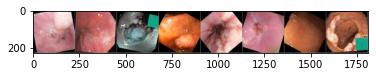

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
images, labels, _ = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [52]:
images.max()

tensor(1.)

# vgg.py


In [53]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
import torch.nn.functional as F
import math
import cv2
import numpy as np
import os

model_urls = {'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth'}      # dict with standard VGG from online directory

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True, att_dir='./results_voc/', training_epoch=15):
        super(VGG, self).__init__()
        self.features = features
        self.nclasses = num_classes
        self.extra_convs = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512,num_classes,1)                    # include 4 new conv layers, last one has 8 outputs for the 8 classes
        )
        self._initialize_weights()
        self.training_epoch = training_epoch
        self.att_dir = att_dir
        if not os.path.exists(self.att_dir):
            os.makedirs(self.att_dir)

    def forward(self, x, epoch=1, label=None, index=None):
        x = self.features(x)
        x = self.extra_convs(x)
        self.map1 = x.clone()
        x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
        x = x.view(-1, self.nclasses)
        
        ###  the online attention accumulation process
        pre_probs = x.clone()
        probs = torch.sigmoid(pre_probs)  # compute the prob
        
        if index != None and epoch > 0:
            atts = self.map1
            atts[atts < 0] = 0
            ind = torch.nonzero(label)

            for i in range(ind.shape[0]):
                batch_index, la = ind[i]
                accu_map_name = '{}{}_{}.png'.format(self.att_dir, batch_index+index, la)
                att = atts[batch_index, la].cpu().data.numpy()
                att = att / (att.max() + 1e-8) * 255
                
                # if this is the last epoch and the image without any accumulation
                if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                    continue
                
                # naively filter out the low quality attention map with prob
                if probs[batch_index, la] < 0.1:  
                    continue
                # print(f'accu_map_name:{accu_map_name}')
                if att is not None:
                    if not os.path.exists(accu_map_name):
                        cv2.imwrite(accu_map_name, att)
                else:
                    accu_att = cv2.imread(accu_map_name, 0)
                    if att is not None:
                        if accu_att is not None:
                            accu_att = np.maximum(accu_att, att)
                            cv2.imwrite(accu_map_name,  accu_att)
         ##############################################

        return x

    def get_heatmaps(self):
        return self.map1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for name, value in self.named_parameters():

            if 'extra' in name:
                if 'weight' in name:
                    groups[2].append(value)
                else:
                    groups[3].append(value)
            else:
                if 'weight' in name:
                    groups[0].append(value)
                else:
                    groups[1].append(value)
        return groups


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'N':
            layers += [nn.MaxPool2d(kernel_size=3, stride=1, padding=1)]
        else:
            if i > 13:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, dilation=2, padding=2)            
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'D1': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'N', 512, 512, 512],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg16(pretrained=False, **kwargs):        # input arg: num classes
    model = VGG(make_layers(cfg['D1']), **kwargs)  
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']), strict=False)      # get pretrained VGG from URL
    return model

# Train loop

In [54]:
# from models import vgg
def get_model(lr=0.001):
    """Function for getting VGG16"""
    model = vgg16(pretrained=True, num_classes=num_classes, training_epoch=epochs)
    model = torch.nn.DataParallel(model).cuda()                         # parallel GPU training
    param_groups = model.module.get_parameter_groups()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    return  model, optimizer

In [60]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model, optimizer = get_model()                      # call get_model(), get modified VGG and optimizer
criterion = torch.nn.CrossEntropyLoss()
# criterion = F.multilabel_soft_margin_loss
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5, verbose=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [61]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):     # save points during training
    """Function for saving checkpoints"""
    savepath = os.path.join(snapshot_dir, filename)
    print(savepath)
    torch.save(state, savepath)
    print(f"Model saved to {savepath}")
    
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']+1, checkpoint['global_counter']

In [62]:
def validate(model, criterion):
  model.eval()
  corrects = 0
  total_sum = 0
  total_loss = 0.0
  with torch.no_grad():
      for idx, dat in enumerate(test_data_loader,0):
          imgs, lbls, _ = dat
          imgs = imgs.to(device)
          lbls = lbls.to(device)

          outputs = model(imgs)
          val_loss = criterion(outputs, lbls)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total_sum += lbls.size(0)
          corrects += (predicted == lbls).sum().item()
          total_loss += loss.item()

  print('Acc val set: %f %%' % (
      100 * corrects / total_sum))
  print('Val loss: ', float(val_loss.cpu().numpy()))
  average_loss = total_loss / total_samples
#   neptune.log_metric('val_loss', average_loss)
  return average_loss

In [63]:
snapshot_dir = './'#'/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/'

In [64]:
global_counter = 0
best_val_loss = float('inf')
current_epoch = 0

print('Training started ...')
PARAMS = {'dataset':dataset,
            'network':'vgg16',
            'epoch_nr': epochs,
            'batch_size': batch_size,
            'optimizer': 'SGD',
            'lr': lr
      }
# neptune.create_experiment('kvasirv2_train', params=PARAMS)

while current_epoch < epochs:  # loop over the dataset multiple times
    total_loss = 0.0
    corrects = 0
    total_samples = 0
    for idx, dat in enumerate(test_data_loader,0):
        inputs, labels, fname = dat
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        # break

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        corrects += torch.sum(predicted == labels)
        total_samples += labels.size(0)
        loss = criterion(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        global_counter += 1

        # print statistics
        total_loss += loss.item()
        if idx % disp_interval == disp_interval-1:    # print every X mini-batches
            print('[%d, %5d] loss: %.3f, corrects: %d' %
                  (current_epoch + 1, idx + 1, total_loss/disp_interval, corrects))
            # neptune.log_metric('train_loss', total_loss/disp_interval)
            # neptune.log_metric('lr', optimizer.param_groups[0]['lr'])
            total_loss = 0.0
    average_accuracy = 100 * corrects / total_samples
    average_loss = total_loss / total_samples

    val_loss = validate(model, criterion)
    scheduler.step(val_loss)
    # neptune.log_metric('epoch_train_acc', average_accuracy)
    print('Avg accuracy: ', average_accuracy)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_checkpoint(
                      {'epoch': current_epoch,
                        'global_counter': global_counter,
                        'state_dict':model.state_dict(),
                        'optimizer':optimizer.state_dict()
                      },
                      filename='%s_epoch_%d.pth' %(dataset, current_epoch))
    
    if current_epoch == epochs-1:
        save_checkpoint(
                        {
                            'epoch': current_epoch,
                            'global_counter': global_counter,
                            'state_dict':model.state_dict(),
                            'optimizer':optimizer.state_dict()
                        },
                        filename='%s_epoch_%d.pth' %(dataset, current_epoch))
        
    current_epoch += 1

print('Finished Training')

Training started ...
[1,   100] loss: 1.461, corrects: 377
Acc val set: 57.250000 %
Val loss:  0.762996256351471
Avg accuracy:  tensor(47.1250, device='cuda:0')
./kvasirv2_epoch_0.pth
Model saved to ./kvasirv2_epoch_0.pth
[2,   100] loss: 0.803, corrects: 526
Acc val set: 74.375000 %
Val loss:  0.9357507228851318
Avg accuracy:  tensor(65.7500, device='cuda:0')
./kvasirv2_epoch_1.pth
Model saved to ./kvasirv2_epoch_1.pth
[3,   100] loss: 0.610, corrects: 600
Acc val set: 85.375000 %
Val loss:  0.38174206018447876
Avg accuracy:  tensor(75., device='cuda:0')
[4,   100] loss: 0.418, corrects: 665
Acc val set: 92.375000 %
Val loss:  0.17442089319229126
Avg accuracy:  tensor(83.1250, device='cuda:0')
./kvasirv2_epoch_3.pth
Model saved to ./kvasirv2_epoch_3.pth
[5,   100] loss: 0.426, corrects: 673
Acc val set: 89.375000 %
Val loss:  0.07888931035995483
Avg accuracy:  tensor(84.1250, device='cuda:0')
./kvasirv2_epoch_4.pth
Model saved to ./kvasirv2_epoch_4.pth
[6,   100] loss: 0.246, corrects

In [65]:
for idx, dat in enumerate(train_data_loader,0):
  imgs, lbls, fname = dat
  break

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

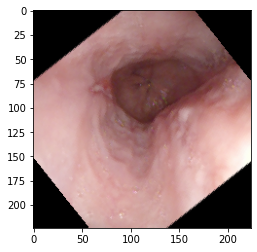

In [67]:
imshow(dat[0][6])

In [68]:
outputs = model(imgs)         # get model output
_, predicted = torch.max(outputs.data, 1)

In [69]:
from sklearn.metrics import confusion_matrix

preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(test_data_loader,0):
            imgs, lbls, fname = dat
            imgs = imgs.to(device)         # to cpu
            lbls = lbls.to(device)         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat((preds_total, predicted.cpu()), dim=0)
            labels_total = torch.cat((labels_total, labels.cpu()), dim=0)

cm_val = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

In [70]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_val, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR val set (800 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from sklearn.metrics import confusion_matrix

preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(train_data_loader,0):
            imgs, lbls, fname = dat
            imgs = imgs.to('cpu')         # to cpu
            lbls = lbls.to('cpu')         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted.to('cpu'))
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls)
              ,dim=0)

cm_train = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

Text(33.0, 0.5, 'Predicted classes')

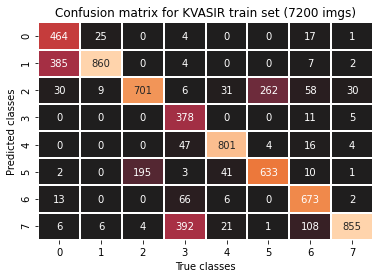

In [ ]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_train, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR train set (7200 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

In [ ]:
# globl_counter = 0
# crf_alpha = [4,24]
# for idx, dat in enumerate(test_data_loader,0):
#           imgs, lbls, fname = dat
#           imgs = imgs.to('cpu')         # to cpu
#           lbls = lbls.to('cpu')         # same
#           outputs = model(imgs)         # get model output
#           _, predicted = torch.max(outputs.data, 1)     # predict label

#           last_featmaps = model.get_heatmaps()          # get featmap
#           for im in range(batch_size):                  # for all images in batch calculate attention
#             orig_img = imgs[im].numpy()

#             orig_img = np.transpose(orig_img, (1, 2, 0))
#             orig_img_size = orig_img.shape[:2]
#             height, width = orig_img_size[0], orig_img_size[1]

#             cam_dict = {}
#             maps = last_featmaps[im].cpu().data.numpy()        # get heatmap of label (single label)
#             cv_im_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)       # make it gray
#             cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

#             labels = lbls.cpu().long().numpy()                            # get label
            
#             att = maps[predicted[im]]                                     # get the heatmap and start processing
#             att[att < 0] = 0
#             att = att / (np.max(att) + 1e-5)
#             cam_max = np.max(att)
#             cam_min = np.min(att)

#             norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)      # normalize to 0 to 1 
#             norm_cam = (norm_cam-cam_min-1e-5) / (cam_max  - cam_min + 1e-5)
#             cam_dict[predicted[im]] = norm_cam                                                # build dictionary
#             att = np.array(att * 255, dtype=np.uint8)                                         # make to image

#             fname_new = fname[im].split('/')
#             im_name = save_dir + fname_new[-1][0:-4]
#             globl_counter += 1

#             out_name = im_name + '_{}.png'.format(predicted[im])                              # just save the image (name is random)
#             # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
#             # att = cv_im_gray * 0.3 + att * 0.7

#             if not os.path.exists(save_dir):
#                     os.makedirs(save_dir)

#             # plt.imsave(out_name, att, cmap=colormap(labels[im])) 

#             if out_cam is not None:
#                 if not os.path.exists(out_cam):
#                     os.makedirs(out_cam)
#                 # np.save(os.path.join(out_cam, fname_new[-1][0:-4] + '.npy'), cam_dict)        # save dictionary at ./results_cam

#             if out_crf is not None:
#                 if not os.path.exists(out_crf):
#                     os.makedirs(out_crf)
#                 for t in crf_alpha:
#                     crf = _crf_with_alpha(orig_img, cam_dict, t)
#                     folder = out_crf + ('_%.1f'%t)
#                     if not os.path.exists(folder):
#                         os.makedirs(folder)
#                     # np.save(os.path.join(folder, fname_new[-1][0:-4] + '.npy'), crf)
#             break
            


In [ ]:
# confusion_matrix = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(dataloaders['val']):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1

In [ ]:
# snapshot_dir = os.path.join(os.getcwd(),'checkpoints/train/exp8')
# snapshot_dir = '/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp8/'